In [1]:
import sys
import os
absFilePath = os.path.abspath('example_state_switching.py')
fileDir = os.path.dirname(absFilePath)
parentDir = os.path.dirname(fileDir)

import func_pytorch as functions
from opt_pytorch import FR_algorithm

import torch
import pickle
import matplotlib.pyplot as plt
from pylab import figure, cm


goal='sync'
bifurcation='high'
noise_strength= 0.0 
realizations=1
noise=0
parameters = functions.set_parameters(goal,bifurcation,parentDir)

# 10 nodes
n_nodes = 10
A = parameters['A'][:n_nodes,:n_nodes]
#A = np.zeros((5,5))
parameters['A'] = A
parameters['N'] = n_nodes


#Set dimensions
T= 400 #simulation and control time 
dt=0.1 #time stepsize
tsteps=int(T/dt) #number of timesteps
d=2 #dimension of each FitzHugh-Nagumo node

#set paraeters of the cost functional
I_p_in= 0.0005 #penalize precision
I_e= 1.0 #penalize control energy should be >0
I_s= 0.0#enforce sparsity

switchfromto='none'
I_p=I_p_in

#choose initial condition for control
control=-torch.ones((tsteps,parameters['N']))*0.002
control=control.reshape(tsteps*parameters['N'])

node_ic=functions.set_random_initial_conds_for_nodes(bifurcation,noise_strength,tsteps,d,dt,parameters,realizations,noise)

args = {
    'tsteps':tsteps,
    'dt':dt,
    'd':d,
    'I_p':I_p,
    'I_e':I_e,
    'I_s':I_s,
    #'target_output':target_output,
    'node_ic':node_ic,
    'realizations':realizations,
    'noise':noise
    }
args.update(parameters)

In [2]:
def create_plot(data,ylabel,title):
    fs=30 #fontsize
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

    # set min and max for scope of y-axis
    minn=torch.min(data)
    maxx=torch.max(data)
    add=(maxx-minn)/25

    im1=ax.plot(torch.arange(0,int(T),dt),data)
    ax.set_xlabel('t',size=fs)
    ax.set_ylabel(ylabel,size=fs)
    ax.set_ylim(minn-add,maxx+add)
    ax.set_title(title,size=fs, pad=20)
    ax.tick_params(labelsize=fs)
    ax.grid(True)
    ax.margins(0) # remove default margins (matplotlib verision 2+)

    return fig.tight_layout()

In [3]:
def cross_correlation_matrix(x , horizen_length , N):
    means = (1/horizen_length) * torch.sum(x, dim=0)
    stds = torch.sqrt(torch.sum((x - means)**2, dim=0))
    stdsgrid = torch.ones((N, 1)) * stds
    stdsgrid = stdsgrid.transpose(0, 1) * stdsgrid
    xcc = x - means
    cross_correlation_mat = torch.matmul(xcc.transpose(0, 1), xcc) / stdsgrid

    return cross_correlation_mat 

In [4]:
nocontrol=torch.zeros((tsteps,parameters['N']))
state_uncontrolled=functions.plot_runge_kutta(functions.ODE_FHN_network,nocontrol, **args)

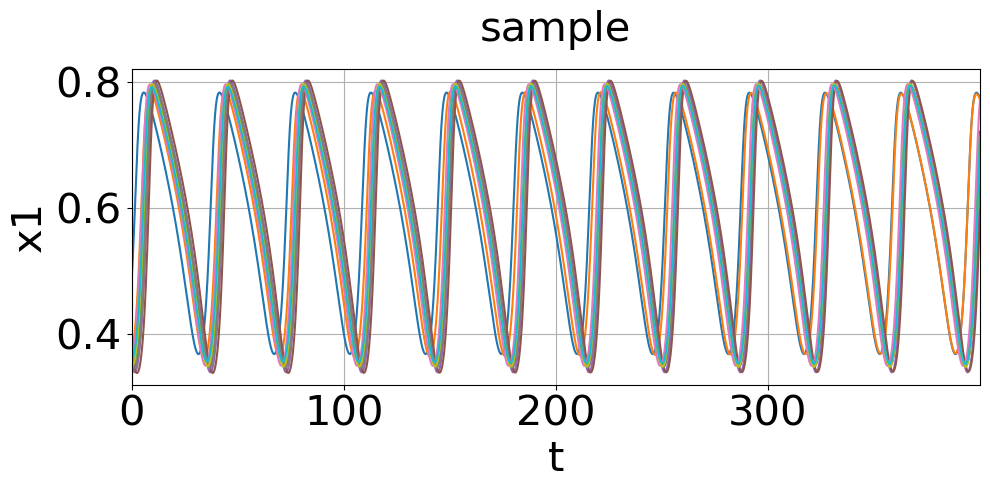

In [5]:
create_plot(state_uncontrolled[:,0,:],'x1','sample')

In [6]:
sample_cc = cross_correlation_matrix(state_uncontrolled[:,0,:] , tsteps , args['N'])

import random
target_anticc = sample_cc.clone()
pairs = [(i, j) for i in range(10) for j in range(i+1, 10)]
selected_pairs = torch.tensor(random.sample(pairs, 10))

# Set the selected elements to -1
for i, j in selected_pairs:
    target_anticc[i, j] = target_anticc[j, i] = -1

In [9]:
target_output = target_anticc
args['target_output'] = target_output

In [ ]:
control=-torch.ones((tsteps,parameters['N']))*0.002
control=control.reshape(tsteps*parameters['N'])

functional=functions.f_sync
gradient=functions.fprime_sync

from opt_pytorch import FR_algorithm
#initialize the control loop
iteration=0 
#warnflag=1-> running, warnflag=0->finished, warnflag=3->error
warnflag=1
#start the optmization
while warnflag == 1 and iteration<5000:
    
    result = FR_algorithm(functional, control, gradient,**args)

    control=result[0]
    warnflag=result[2]
    iteration+=result[4]
    
    #make dictionary to save the result
    out={
        'optimal_control':control.reshape(tsteps,parameters['N']),
        'functional':result[1],
        'gradient_norm':result[3],
        'warnflag':result[2],
        'iterations':iteration,
        'node_ic':node_ic,
        'target_output':target_output,
        'external_current':parameters['mu'],
        'coupling_strength':parameters['sigma'],
        'noise_strength':noise_strength,
        'noise':noise,
        'I_p':I_p,
        'I_e':I_e,
        'I_s':I_s,
        'T':T,
        'bifurcation':bifurcation,
        'goal':goal
        }
    
    print('Iteration ',iteration,' finished at gnorm',result[3],'with f',result[1],'with warnflag',result[2])
print('Code finished after ',iteration,' iterations with warnflag',result[2])  

tensor([0.0021, 0.0019, 0.0008,  ..., 0.0011, 0.0011, 0.0011],
       grad_fn=<AddBackward0>) tensor(0.0363, grad_fn=<AddBackward0>) tensor([0.0022, 0.0019, 0.0005,  ..., 0.0011, 0.0011, 0.0011],
       grad_fn=<ReshapeAliasBackward0>)
tensor([0.0021, 0.0019, 0.0008,  ..., 0.0011, 0.0011, 0.0011],
       grad_fn=<AddBackward0>) tensor(0.0363, grad_fn=<AddBackward0>) tensor([0.0022, 0.0019, 0.0005,  ..., 0.0011, 0.0011, 0.0011],
       grad_fn=<ReshapeAliasBackward0>)


In [57]:
import sys
import os
absFilePath = os.path.abspath('example_state_switching.py')
fileDir = os.path.dirname(absFilePath)
parentDir = os.path.dirname(fileDir)

import functions as functions
from FRoptimize import FR_algorithm

import numpy as np
import pickle
import matplotlib.pyplot as plt
from pylab import figure, cm

goal='sync'
bifurcation='high'
noise_strength= 0.0 
realizations=1
noise=0
parameters = functions.set_parameters(goal,bifurcation,parentDir)

# 10 nodes
n_nodes = 10
A = parameters['A'][:n_nodes,:n_nodes]
parameters['A'] = A
parameters['N'] = n_nodes


#Set dimensions
T= 400 #simulation and control time 
dt=0.1 #time stepsize
tsteps=int(T/dt) #number of timesteps
d=2 #dimension of each FitzHugh-Nagumo node

#set paraeters of the cost functional
I_p_in= 0.0005 #penalize precision
I_e= 1.0 #penalize control energy should be >0
I_s= 0.0#enforce sparsity

switchfromto='none'
I_p=I_p_in

#choose initial condition for control
control=-np.ones((tsteps,parameters['N']))*0.002
control=control.reshape(tsteps*parameters['N'])

node_ic=functions.set_random_initial_conds_for_nodes(bifurcation,noise_strength,tsteps,d,dt,parameters,realizations,noise)
#ic_state_high=functions.set_random_initial_conds_for_nodes('high',noise_strength,tsteps,d,dt,parameters_high,realizations,noise)
target_output=np.ones((parameters['N'],parameters['N']))

args = {
    'tsteps':tsteps,
    'dt':dt,
    'd':d,
    'I_p':I_p,
    'I_e':I_e,
    'I_s':I_s,
    'target_output':target_output,
    'node_ic':node_ic,
    'realizations':realizations,
    'noise':noise
    }
args.update(parameters)

/Users/shi/Desktop/individual/OptimalControl-master/src_and_example/functions.py:848: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  k1 = dt* ODE_FHN_network(x[ts],ts,control,tsteps , d , dt , N , alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A)


In [58]:
#In this case we want to find an optimal control that induces a switching 
#from an initial low state to a high target state. The uncontrolled state and 
#the target state are plotted:

def create_plot(data,ylabel):
    fs=10 #fontsize
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

    # set min and max for scope of y-axis
    minn=np.min(data)
    maxx=np.max(data)
    add=(maxx-minn)/25

    im1=ax.plot(np.arange(0,int(T),dt),data)
    ax.set_xlabel('t',size=fs)
    ax.set_ylabel(ylabel,size=fs)
    ax.set_ylim(minn-add,maxx+add)
    #ax.set_title(title,size=fs, pad=20)
    ax.tick_params(labelsize=fs)
    ax.grid(True)
    ax.margins(0) # remove default margins (matplotlib verision 2+)

    return fig.tight_layout()


In [59]:
nocontrol=np.zeros((tsteps,parameters['N']))
state_uncontrolled=functions.plot_runge_kutta(functions.ODE_FHN_network,nocontrol, **args)

In [60]:
def cross_correlation_matrix(x , tsteps , N):
    means = (1/tsteps) * np.sum(x,axis=0)
    stds =  ((x-means)**2).sum(axis=0)**(1/2) 
    stdsgrid= np.ones((N,1))*stds
    stdsgrid= stdsgrid.transpose()*stdsgrid
    xcc = (x-means)
    cross_correlation_mat= np.dot(xcc.transpose(), xcc)/stdsgrid

    return cross_correlation_mat

In [61]:
sample_cc = cross_correlation_matrix(state_uncontrolled[:,0,:], tsteps , n_nodes)

In [7]:
import random
target_anticc = sample_cc.copy()
pairs = [(i, j) for i in range(10) for j in range(i+1, 10)]
selected_pairs = random.sample(pairs, 10)

# Set the selected elements to -1
for i, j in selected_pairs:
    target_anticc[i, j] = target_anticc[j, i] = -1

print(target_anticc)

[[ 1.         -1.          0.85889097  0.94419896  0.73955985  0.98070583
  -1.         -1.         -1.          0.97316943]
 [-1.          1.         -0.09699916 -0.1416039  -0.10711756 -0.14060342
  -0.06179872 -0.16402195 -0.01148525 -0.17760449]
 [ 0.85889097 -0.09699916  1.          0.69216409  0.97710877  0.82089961
   0.99152346  0.43406836  0.960756    0.82302257]
 [ 0.94419896 -0.1416039   0.69216409  1.          0.54634006 -1.
  -1.          0.92517419  0.78125835 -1.        ]
 [ 0.73955985 -0.10711756  0.97710877  0.54634006  1.          0.69505298
   0.95363913  0.2790207   0.90166165  0.6999958 ]
 [ 0.98070583 -0.14060342  0.82089961 -1.          0.69505298  1.
  -1.          0.82018531  0.87137268 -1.        ]
 [-1.         -0.06179872  0.99152346 -1.          0.95363913 -1.
   1.          0.48853228 -1.          0.84500661]
 [-1.         -0.16402195  0.43406836  0.92517419  0.2790207   0.82018531
   0.48853228  1.          0.56176298  0.81648202]
 [-1.         -0.0114852

In [8]:
target_output = target_anticc
args['target_output'] = target_output

In [9]:
functional=functions.f_sync
gradient=functions.fprime_sync

#initialize the control loop
iteration=0 
#warnflag=1-> running, warnflag=0->finished, warnflag=3->error
warnflag=1
#start the optmization
result = FR_algorithm(functional, control, gradient, max_k=1000, **args)
control=result[0]
warnflag=result[2]
iteration+=result[4]
print('Code finished after ',iteration,' iterations with warnflag',result[2])

gnorm 7.976634300533387e-05 uknorm 8.478986297560465e-06
Code finished after  89  iterations with warnflag 0


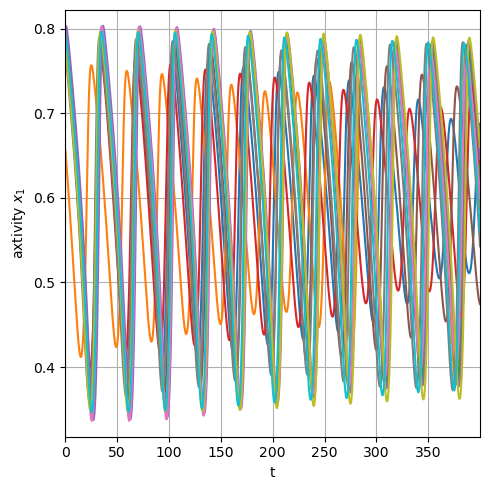

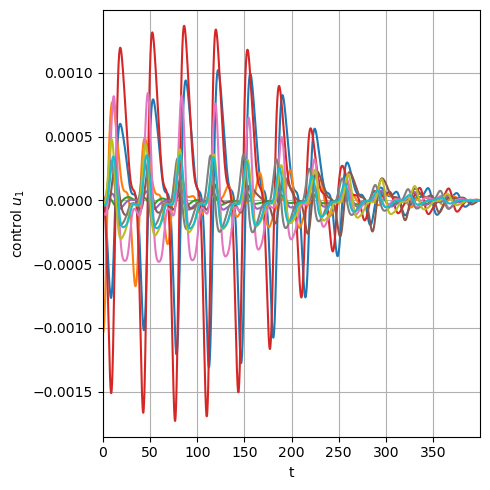

In [10]:
#The results can now be plottet:

#calculate the controlled state
control=control.reshape(tsteps,parameters['N'])
state_controlled=functions.plot_runge_kutta(functions.ODE_FHN_network,control, **args)

create_plot(state_controlled[:,0,:],'axtivity $x_{1}$')
plt.show()
create_plot(control,'control $u_{1}$')
plt.show()


In [11]:
controlled_cc = cross_correlation_matrix(state_controlled[:,0,:], tsteps , n_nodes)

In [12]:
print(controlled_cc)

[[ 1.         -0.49980283  0.19860298  0.65113728  0.07954685  0.8141279
   0.1804087   0.64341966  0.18747622  0.37294749]
 [-0.49980283  1.          0.04782856 -0.22410295  0.05509216 -0.45507852
   0.05691688 -0.07266491  0.1056929  -0.02517508]
 [ 0.19860298  0.04782856  1.          0.02222995  0.97124345  0.51416594
   0.99052329  0.64390734  0.94523992  0.92394341]
 [ 0.65113728 -0.22410295  0.02222995  1.         -0.0269753   0.27761045
  -0.00789043  0.29278527  0.1099031   0.06303524]
 [ 0.07954685  0.05509216  0.97124345 -0.0269753   1.          0.37787445
   0.96930338  0.47312184  0.95066482  0.81640464]
 [ 0.8141279  -0.45507852  0.51416594  0.27761045  0.37787445  1.
   0.50604038  0.84069525  0.40653239  0.71430968]
 [ 0.1804087   0.05691688  0.99052329 -0.00789043  0.96930338  0.50604038
   1.          0.62742007  0.94595147  0.91557036]
 [ 0.64341966 -0.07266491  0.64390734  0.29278527  0.47312184  0.84069525
   0.62742007  1.          0.54634437  0.85712406]
 [ 0.1874

In [13]:
print(np.sum((target_anticc-sample_cc)**2), np.sum((target_anticc-controlled_cc)**2))

67.02869458930026 44.4582495030503


In [19]:
#random intial condition
node_ic=functions.set_random_initial_conds_for_nodes(bifurcation,noise_strength,tsteps,d,dt,parameters,realizations,noise)
args['node_ic'] = node_ic
#initialize the control loop
iteration=0 
#warnflag=1-> running, warnflag=0->finished, warnflag=3->error
warnflag=1
#start the optmization
result = FR_algorithm(functional, control, gradient, max_k=1000, **args)
control=result[0]
warnflag=result[2]
iteration+=result[4]
print('Code finished after ',iteration,' iterations with warnflag',result[2])

control=control.reshape(tsteps,parameters['N'])
state_controlled=functions.plot_runge_kutta(functions.ODE_FHN_network,control, **args)
nocontrol=np.zeros((tsteps,parameters['N']))
state_uncontrolled=functions.plot_runge_kutta(functions.ODE_FHN_network,nocontrol, **args)

In [14]:
# Initialize lists to store results for all iterations
all_controls = []
all_states_controlled = []
all_states_uncontrolled = []

functional=functions.f_sync
gradient=functions.fprime_sync
# Repeat the process 100 times
for i in range(1000):
    # Random initial condition
    node_ic = functions.set_random_initial_conds_for_nodes(bifurcation, noise_strength, tsteps, d, dt, parameters, realizations, noise)
    args['node_ic'] = node_ic
    #choose initial condition for control
    control=-np.ones((tsteps,parameters['N']))*0.002
    control=control.reshape(tsteps*parameters['N'])
    
    # Initialize the control loop
    iteration = 0 
    # warnflag=1-> running, warnflag=0->finished, warnflag=3->error
    warnflag = 1
    
    # Start the optimization
    result = FR_algorithm(functional, control, gradient, max_k=1000, **args)
    control = result[0]
    warnflag = result[2]
    iteration += result[4]
    if i%50 == 0:
        print('Code finished after ', iteration, ' iterations with warnflag', result[2])
    
    control = control.reshape(tsteps, parameters['N'])
    state_controlled = functions.plot_runge_kutta(functions.ODE_FHN_network, control, **args)
    nocontrol = np.zeros((tsteps, parameters['N']))
    state_uncontrolled = functions.plot_runge_kutta(functions.ODE_FHN_network, nocontrol, **args)
    
    # Store results
    all_controls.append(control)
    all_states_controlled.append(state_controlled)
    all_states_uncontrolled.append(state_uncontrolled)


gnorm 0.00010061850110933655 uknorm 1.865660026230246e-05
Code finished after  24  iterations with warnflag 0
gnorm 9.955259954135941e-05 uknorm 0.00013482022514757448
gnorm 0.00010054969861456042 uknorm 9.57962277418076e-06
gnorm 9.164938847966561e-05 uknorm 1.1839007765827511e-05
gnorm 9.703637980423975e-05 uknorm 1.0987747824801278e-05
gnorm 6.24720078617869e-05 uknorm 5.4129292087169104e-06
gnorm 5.442837147320688e-05 uknorm 1.7604729179436724e-05
gnorm 6.995538028570561e-05 uknorm 1.8955158666370377e-05
gnorm 7.305413093160857e-05 uknorm 1.6682361489140773e-05
gnorm 9.912557179788772e-05 uknorm 5.7660866017349155e-05
gnorm 5.4653731611762485e-05 uknorm 2.3737371395315035e-05
gnorm 4.817812206709326e-05 uknorm 1.8411057046524917e-05
gnorm 6.511556641711517e-05 uknorm 9.41956201517321e-06
gnorm 7.927454083538977e-05 uknorm 5.538170391589537e-06
gnorm 9.396972684495787e-05 uknorm 9.28929958299643e-06
gnorm 7.437913877767432e-05 uknorm 9.606636194128739e-06
gnorm 9.161941162249957e-05

gnorm 3.788986080645925e-05 uknorm 8.963989127039242e-06
gnorm 7.25634814262477e-05 uknorm 8.52354324608665e-06
gnorm 8.007156585637231e-05 uknorm 5.176569811790816e-06
gnorm 9.850153448640508e-05 uknorm 1.5282612187922243e-05
gnorm 5.2541355612250825e-05 uknorm 2.1219831397418414e-05
gnorm 8.857340719142033e-05 uknorm 5.266262418666089e-06
gnorm 5.928846114088286e-05 uknorm 1.133727134254429e-05
gnorm 8.000329035839199e-05 uknorm 9.17508250567996e-06
gnorm 0.00010066767270280538 uknorm 4.071245207193852e-05
gnorm 5.344104091431251e-05 uknorm 7.578717052920351e-06
Code finished after  38  iterations with warnflag 0
gnorm 7.840931033920961e-05 uknorm 1.071662256027484e-05
gnorm 9.994191888844481e-05 uknorm 6.141063209001273e-06
gnorm 8.385868829200241e-05 uknorm 2.0342384891365107e-05
gnorm 9.548319734441961e-05 uknorm 7.287257514265472e-06
gnorm 7.406154253679657e-05 uknorm 6.1535082022288416e-06
gnorm 0.00010000585202481969 uknorm 2.508688892442052e-05
gnorm 7.840635563905298e-05 ukno

gnorm 9.149856703036165e-05 uknorm 3.8905262867467046e-06
gnorm 8.192899642300687e-05 uknorm 8.042012756819596e-06
gnorm 2.4191822869264765e-05 uknorm 6.77662580517201e-06
gnorm 9.2794769128582e-05 uknorm 6.8754208818557795e-06
gnorm 9.41448876805366e-05 uknorm 2.160641873747023e-05
gnorm 9.752324462736781e-05 uknorm 1.1944390389331599e-05
gnorm 0.00010089069800388496 uknorm 1.578885042126995e-05
gnorm 8.83472297616972e-05 uknorm 1.9509856177618297e-05
gnorm 8.636322222853077e-05 uknorm 2.404393536378042e-05
gnorm 8.281676180579086e-05 uknorm 3.4593521364981e-05
gnorm 8.97626938790653e-05 uknorm 1.2441276913035008e-05
gnorm 6.921037266891905e-05 uknorm 2.1530055461281257e-05
gnorm 7.929245351020239e-05 uknorm 1.777762057420234e-05
gnorm 8.804932070773726e-05 uknorm 6.795217158254031e-06
gnorm 9.603360625598414e-05 uknorm 3.436257701611243e-06
gnorm 7.795043962363526e-05 uknorm 0.00014492769679693226
gnorm 9.104095646459125e-05 uknorm 6.076829865085979e-06
gnorm 7.439139342277292e-05 uk

gnorm 6.061054011191082e-05 uknorm 4.377372333174627e-05
gnorm 9.826733942766108e-05 uknorm 5.924929556937533e-06
gnorm 8.515390807771971e-05 uknorm 2.201439576804355e-05
gnorm 9.800271069988276e-05 uknorm 1.663929928845051e-05
gnorm 8.52666923582267e-05 uknorm 7.998359301432303e-06
gnorm 9.235211117202837e-05 uknorm 6.207634233818286e-06
gnorm 9.878623282893583e-05 uknorm 2.1845319434528245e-05
gnorm 8.859564882212376e-05 uknorm 1.210763352779004e-05
gnorm 7.16638558423941e-05 uknorm 2.401771445917113e-05
gnorm 9.142023839844014e-05 uknorm 1.906153082836446e-05
gnorm 9.947821870424255e-05 uknorm 1.1900024597083286e-05
gnorm 5.377601382745823e-05 uknorm 1.0608395003769552e-05
gnorm 9.568060045209907e-05 uknorm 4.422426172169189e-06
gnorm 7.491532769899928e-05 uknorm 1.0279291435557844e-05
gnorm 7.348904316242322e-05 uknorm 9.999934224961182e-06
gnorm 8.917956782586564e-05 uknorm 8.49175987631054e-06
gnorm 8.591401676978047e-05 uknorm 1.6355530046718338e-05
gnorm 8.479412148804544e-05 u

gnorm 5.3594380005740974e-05 uknorm 5.91047105202077e-06
gnorm 9.550978509540418e-05 uknorm 2.4569981091934583e-06
gnorm 4.730354473200111e-05 uknorm 2.1217656237389106e-05
gnorm 9.274627555867472e-05 uknorm 7.764889985488032e-06
gnorm 6.011402404841777e-05 uknorm 8.625476377090938e-06
gnorm 8.81130691381593e-05 uknorm 1.743514160980797e-05
gnorm 7.720433202141664e-05 uknorm 2.987135906122487e-06
gnorm 9.704232005954645e-05 uknorm 1.519870732201163e-05
gnorm 9.496824311735976e-05 uknorm 2.65005173222529e-05
gnorm 9.776567265109887e-05 uknorm 9.123156549187229e-06
gnorm 7.601759532271479e-05 uknorm 3.066089274955013e-05
gnorm 8.309330941910873e-05 uknorm 2.323550590973742e-05
gnorm 6.056271032102911e-05 uknorm 6.720655569509475e-06
gnorm 4.382557147248906e-05 uknorm 1.7440198561264296e-05
gnorm 7.401160040722103e-05 uknorm 1.2006580004973039e-05
gnorm 6.549539633761534e-05 uknorm 1.1279745203382398e-05
gnorm 9.770786940369145e-05 uknorm 1.1011068062832287e-05
gnorm 3.8289390843704025e-0

gnorm 9.512003297064994e-05 uknorm 8.138289041940971e-06
gnorm 6.57229250499655e-05 uknorm 1.9990169191576226e-05
gnorm 6.861633729264354e-05 uknorm 2.0025473467387162e-05
gnorm 9.872000931296756e-05 uknorm 2.241607771621794e-05
gnorm 7.422468373063647e-05 uknorm 7.712003709795055e-06
gnorm 9.868967257581178e-05 uknorm 2.533975679820666e-06
gnorm 3.6510031204403334e-05 uknorm 1.1657083823688212e-05
gnorm 8.901192757635933e-05 uknorm 1.7928296672870686e-05
gnorm 7.159559406565261e-05 uknorm 5.3276308555638176e-06
gnorm 8.146658662768706e-05 uknorm 8.039371722105766e-05
gnorm 9.943113013112298e-05 uknorm 1.1147169824249695e-05
gnorm 7.440381955297172e-05 uknorm 3.4747850011268306e-05
gnorm 7.487205493899706e-05 uknorm 5.81250870903844e-06
gnorm 9.073799372905303e-05 uknorm 8.999171292046614e-06
gnorm 6.905503792884631e-05 uknorm 9.250140061305579e-06
gnorm 6.155095991470941e-05 uknorm 7.319542390282199e-06
gnorm 9.440818114388226e-05 uknorm 6.428074052517319e-06
gnorm 9.958451256597903e-

gnorm 8.4313775490038e-05 uknorm 1.1170857032525693e-05
gnorm 6.676755054713297e-05 uknorm 2.0484496484033223e-05
gnorm 5.433243193275425e-05 uknorm 9.58133526409756e-06
gnorm 9.772601322228158e-05 uknorm 6.117841053863635e-06
gnorm 6.653090965494401e-05 uknorm 1.941042767568315e-05
gnorm 8.692960569982268e-05 uknorm 3.054371895986393e-06
gnorm 7.31548280391047e-05 uknorm 1.8570724696375263e-05
gnorm 5.2160973341157445e-05 uknorm 1.909516843797603e-06
Code finished after  150  iterations with warnflag 0
gnorm 0.00010008713802754838 uknorm 1.1277416924683004e-05
gnorm 8.832846021437652e-05 uknorm 5.969864905629521e-06
gnorm 7.850316205517478e-05 uknorm 2.1164965138432447e-05
gnorm 7.470878014847115e-05 uknorm 9.695448761202347e-06
gnorm 5.165677146254659e-05 uknorm 2.382250400837795e-05
gnorm 8.813055836562973e-05 uknorm 2.2383254963846645e-05
gnorm 8.397954800717499e-05 uknorm 3.3755941206267334e-05
gnorm 2.1995249381426664e-05 uknorm 1.0860116523476104e-05
gnorm 9.49335877842057e-05 u

gnorm 6.543728689326518e-05 uknorm 1.7512282396338428e-05
gnorm 5.036879924496542e-05 uknorm 7.342451325128554e-06
gnorm 9.98117546845142e-05 uknorm 1.3794170399531423e-05
gnorm 8.525059616753562e-05 uknorm 1.0369807285628328e-05
gnorm 9.897746317511077e-05 uknorm 2.3833842691308458e-05
gnorm 9.484765264622147e-05 uknorm 1.0908897103293139e-05
gnorm 7.053245464762862e-05 uknorm 1.4105358736204521e-05
gnorm 9.97371020459866e-05 uknorm 3.071317961706767e-06
gnorm 3.645486418185314e-05 uknorm 1.0583893943915288e-05
gnorm 9.586095528283658e-05 uknorm 3.442358625435106e-06
gnorm 6.83354523790303e-05 uknorm 2.226987389610446e-05
gnorm 8.773266009796834e-05 uknorm 1.2235097727170737e-05
gnorm 6.740141588531352e-05 uknorm 2.601056188885221e-06
gnorm 7.169590121544871e-05 uknorm 2.1975744556671558e-05
gnorm 7.074720924678116e-05 uknorm 6.014915283209616e-06
gnorm 9.463956941925685e-05 uknorm 1.2516416889227309e-05


In [28]:
all_states_uncontrolled[0].shape

(4000, 2, 10)

In [29]:
all_controls[0].shape

(4000, 10)

In [15]:
len(all_controls)

1000

In [16]:
from sklearn.linear_model import LinearRegression

# Reshape data
X = np.vstack(all_states_uncontrolled)  # Stack all matrices vertically
y = np.vstack(all_controls)  # Stack and flatten control arrays

# Split the data into train and test (optional but recommended)
from sklearn.model_selection import train_test_split

# Reshape X to be 2D
X_reshaped = X.reshape(-1, 2 * 10)  # Flatten the last two dimensions

# Interleave rows in X to match with y
X_interleaved = np.vstack([X_reshaped[i::2] for i in range(2)])
print(X_interleaved.shape,y.shape)
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_interleaved, y, test_size=0.2, random_state=42)

# Train the linear regressor
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predict on test set (optional)
y_pred = regressor.predict(X_test)

# Evaluate the performance (optional)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on test set: {mse:.10f}")


(4000000, 20) (4000000, 10)
Mean Squared Error on test set: 0.0000000786


In [19]:
import pickle

with open('linear_regression_data.pkl', 'wb') as f:
    pickle.dump((X, y), f)

In [3]:
import pickle
# Load using pickle
with open('linear_regression_data.pkl', 'rb') as f:
    X, y = pickle.load(f)


In [10]:
import numpy as np

# Assuming X is the stacked array
num_arrays = 1000
size_each_array = 4000

list_of_arrays = np.array_split(X, num_arrays)


In [17]:
list_of_y = np.array_split(y, num_arrays)

In [65]:
list_of_y[0].shape

(4000, 10)

In [34]:
list_of_arrays_100 = [arr[:100, 0, :] for arr in list_of_arrays]
list_of_arrays_y = [arr[:100, :] for arr in list_of_y]

In [66]:
target_output = target_anticc
args['target_output'] = target_output

In [68]:
cc_uncontrolled=cross_correlation_matrix(list_of_arrays[1][:,0,:], tsteps , n_nodes)
control=list_of_y[1]
node_ic = list_of_arrays[1][0,0,:]
args['node_ic'] = node_ic
state_controlled=functions.plot_runge_kutta(functions.ODE_FHN_network,control, **args)
cc_controlled = cross_correlation_matrix(state_controlled[:,0,:], tsteps , n_nodes)
mse_1 = np.sum((target_anticc-cc_uncontrolled)**2)
mse_2 = np.sum((target_anticc-cc_controlled)**2)
print(mse_1,mse_2)

80.09736843782302 100.68002109024958


In [69]:
print(cc_controlled)

[[1.         0.95884561 0.91669289 0.95735468 0.95095431 0.96243154
  0.97544671 0.94263204 0.92775953 0.92923208]
 [0.95884561 1.         0.98041347 0.99116104 0.95572454 0.96269719
  0.96409519 0.98370957 0.97519075 0.98583285]
 [0.91669289 0.98041347 1.         0.99235048 0.97064181 0.96847455
  0.96085807 0.99608997 0.99687669 0.9992564 ]
 [0.95735468 0.99116104 0.99235048 1.         0.98319448 0.98523196
  0.98356029 0.99817541 0.99392268 0.99598368]
 [0.95095431 0.95572454 0.97064181 0.98319448 1.         0.99874509
  0.99514676 0.98635355 0.98589066 0.97508302]
 [0.96243154 0.96269719 0.96847455 0.98523196 0.99874509 1.
  0.99805151 0.9859813  0.98329634 0.97446093]
 [0.97544671 0.96409519 0.96085807 0.98356029 0.99514676 0.99805151
  1.         0.98097537 0.97575942 0.9682605 ]
 [0.94263204 0.98370957 0.99608997 0.99817541 0.98635355 0.9859813
  0.98097537 1.         0.99867661 0.99807245]
 [0.92775953 0.97519075 0.99687669 0.99392268 0.98589066 0.98329634
  0.97575942 0.998676

In [40]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Convert the list of arrays to a 2D array
X = np.vstack(list_of_arrays_100)#.flatten()

# Assuming each target corresponds to one of your trajectories
y = np.vstack(list_of_arrays_y)#.flatten()
print(X.shape,y.shape)
# Instantiate the linear regression model and fit it
reg = LinearRegression().fit(X, y)


(100000, 10) (100000, 10)
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [42]:
# Predict on test set (optional)
y_pred = reg.predict(X)

# Evaluate the performance (optional)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_pred, y)
print(f"Mean Squared Error on test set: {mse:.10f}")

Mean Squared Error on test set: 0.0000001684


In [43]:
from sklearn.metrics import r2_score
r2 = r2_score(y, y_pred)
print(f"R-squared value: {r2:.2f}")

R-squared value: 0.21


In [54]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
poly = PolynomialFeatures(degree=5)
model = make_pipeline(poly, LinearRegression())
model.fit(X, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=5)),
                ('linearregression', LinearRegression())])

In [55]:
y_pred_poly = model.predict(X)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_pred_poly, y)
print(f"Mean Squared Error on test set: {mse:.10f}")
r2 = r2_score(y, y_pred_poly)
print(f"R-squared value: {r2:.2f}")

Mean Squared Error on test set: 0.0000000215
R-squared value: 0.92


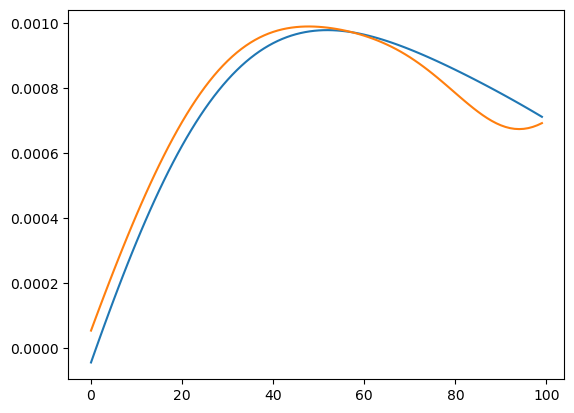

In [56]:
plt.plot(y[:100,1])
plt.plot(y_pred_poly[:100,1])
plt.show()

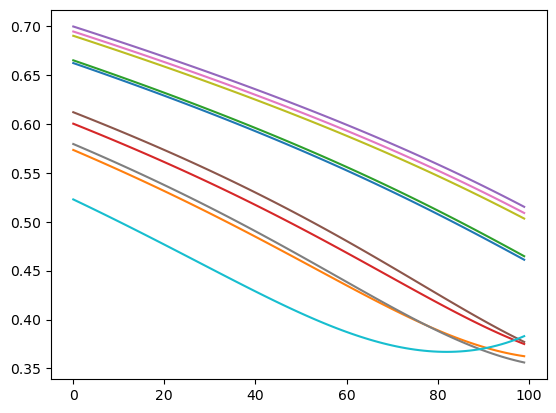

In [24]:
import matplotlib.pyplot as plt
plt.plot(list_of_arrays[0][:100,0,:])
plt.show()

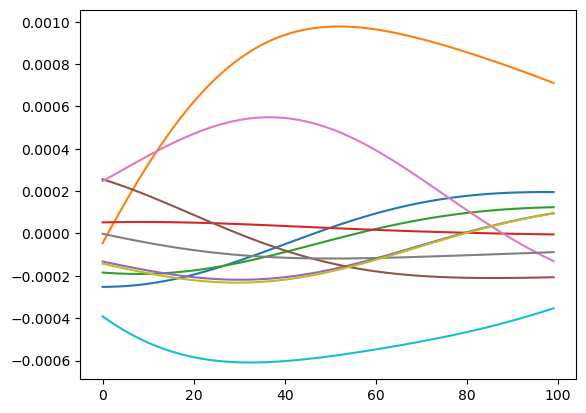

In [23]:
plt.plot(list_of_y[0][:100,:])
plt.show()

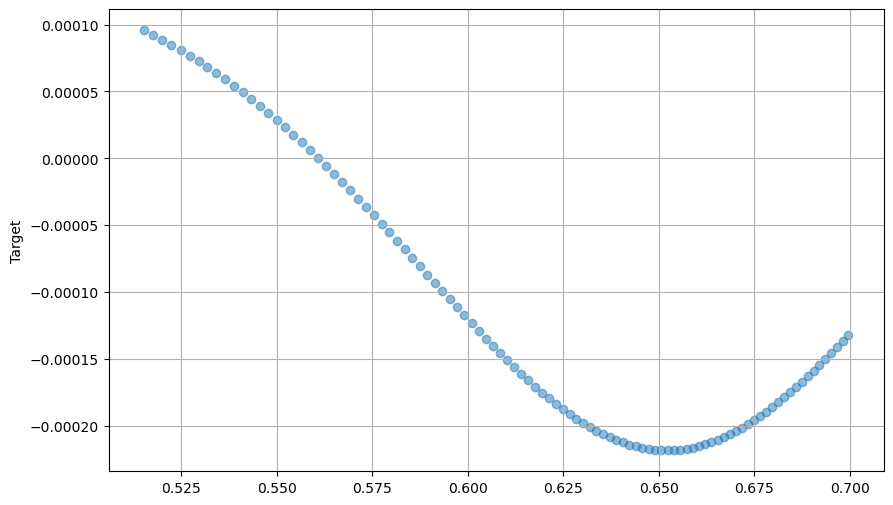

In [32]:
plt.figure(figsize=(10, 6))
plt.scatter(list_of_arrays[0][:100,0,4], list_of_y[0][:100,4], alpha=0.5)
plt.ylabel('Target')
plt.grid(True)
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
X_train.shape

(3200000, 2, 10)

In [20]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f"R-squared value: {r2:.2f}")


R-squared value: 0.00


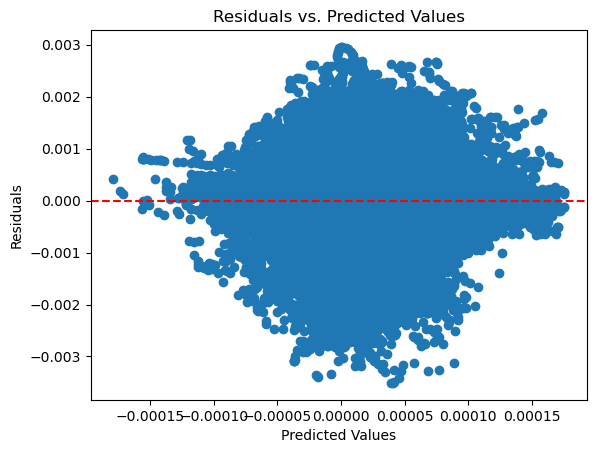

In [57]:
import matplotlib.pyplot as plt

residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()



In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Create polynomial features (let's try a 2nd degree polynomial as an example)
poly = PolynomialFeatures(degree=3)

# Create a pipeline that first creates polynomial features, then applies linear regression
model = make_pipeline(poly, LinearRegression())

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred_poly = model.predict(X_test)

# Evaluate the performance
mse_poly = mean_squared_error(y_test, y_pred_poly)
print(f"Mean Squared Error on test set with polynomial regression: {mse_poly:.10f}")

# You can also get R^2 value for the polynomial regression
r2_poly = model.score(X_test, y_test)
print(f"R^2 value for polynomial regression: {r2_poly:.5f}")


In [33]:
all_controls[0]

array([[-1.88631439e-05, -2.78233869e-04, -4.61789794e-05, ...,
         2.43252297e-06, -4.24443778e-05, -2.70788247e-06],
       [-2.49539340e-05, -3.00650846e-04, -4.62618903e-05, ...,
         1.47373980e-06, -4.28318098e-05, -2.82786961e-06],
       [-3.14103319e-05, -3.23896706e-04, -4.62854207e-05, ...,
         4.45804094e-07, -4.31934028e-05, -2.95096996e-06],
       ...,
       [-4.53822935e-07,  1.02613285e-07,  6.13495542e-08, ...,
        -2.89547421e-07,  1.15631102e-07, -1.03460997e-07],
       [-2.23373203e-07,  5.31594264e-08,  3.15981140e-08, ...,
        -1.43102448e-07,  5.88219379e-08, -5.17510549e-08],
       [-9.59974604e-11, -9.59974604e-11, -9.59974604e-11, ...,
        -9.59974604e-11, -9.59974604e-11, -9.59974604e-11]])

In [34]:
all_controls[1]

array([[-5.07525398e-05,  1.87140100e-05,  1.99564380e-04, ...,
         1.54660399e-04,  1.22376976e-05,  4.89696162e-04],
       [-4.90816576e-05,  1.87460041e-05,  1.92751594e-04, ...,
         1.30250521e-04,  1.16131651e-05,  4.68632892e-04],
       [-4.75132110e-05,  1.87785380e-05,  1.86357089e-04, ...,
         1.05916749e-04,  1.10202209e-05,  4.47143519e-04],
       ...,
       [-1.82239221e-07, -5.03504608e-07,  6.73474291e-07, ...,
        -1.68858458e-07, -3.33889252e-07, -2.82985822e-07],
       [-1.56355429e-07, -3.13042673e-07,  2.69286415e-07, ...,
        -1.52035942e-07, -2.32695399e-07, -2.10124293e-07],
       [-1.32108997e-07, -1.32108997e-07, -1.32108997e-07, ...,
        -1.32108997e-07, -1.32108997e-07, -1.32108997e-07]])

In [45]:
print(all_controls[1].shape,y_pred.shape)

(4000, 10) (80000, 10)


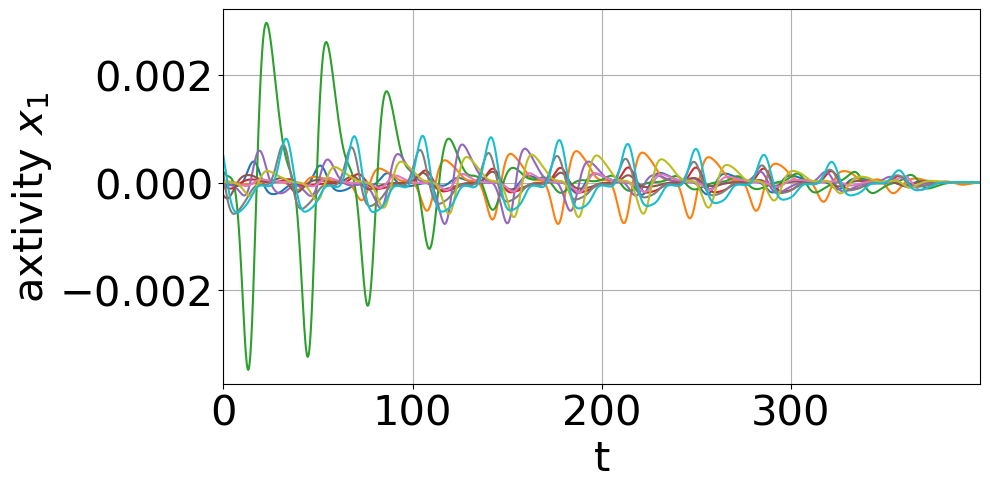

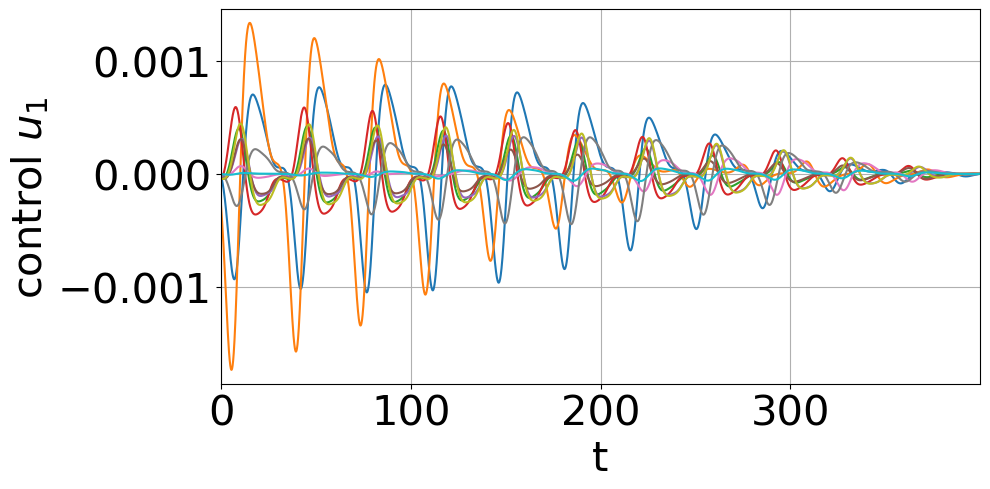

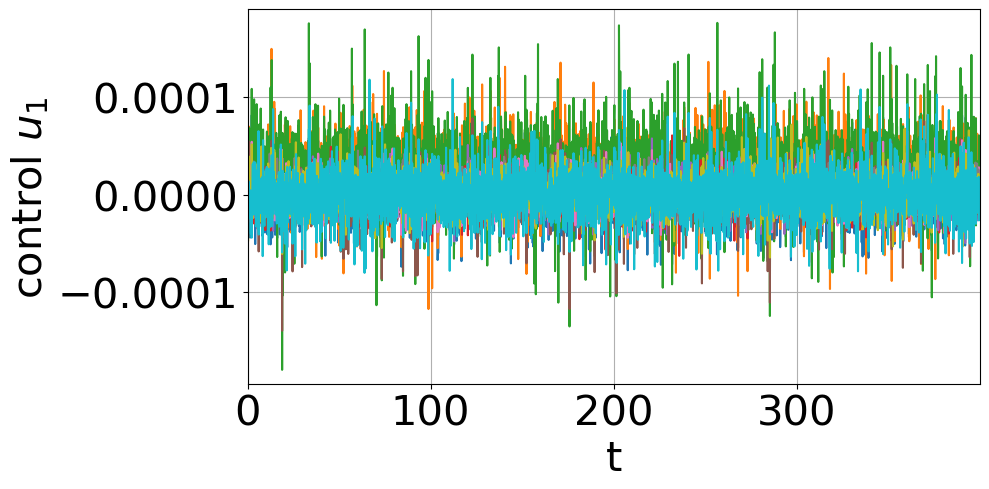

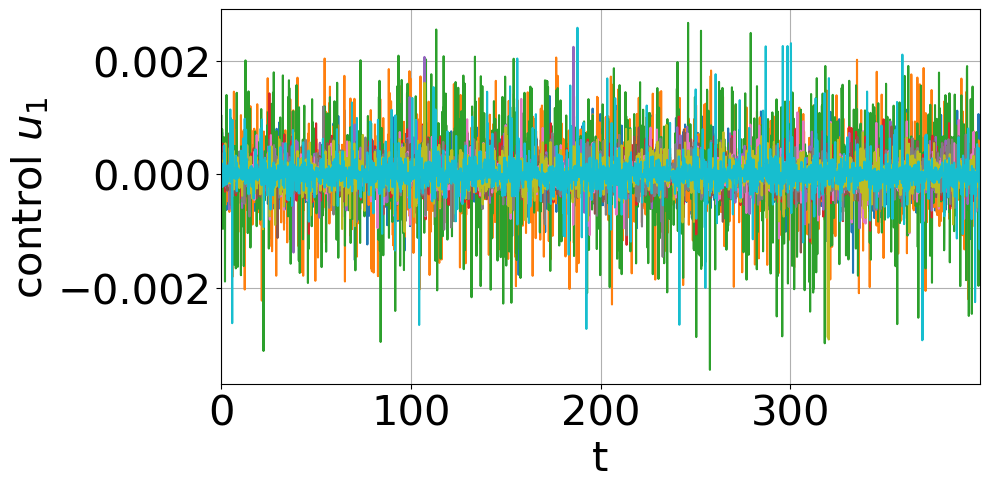

In [47]:
create_plot(all_controls[1],'axtivity $x_{1}$')
plt.show()
create_plot(all_controls[0],'control $u_{1}$')
plt.show()
create_plot(y_pred[:4000,:],'control $u_{1}$')
plt.show()
create_plot(y_test[:4000,:],'control $u_{1}$')
plt.show()

In [50]:
from sklearn.linear_model import LinearRegression

# Reshape data
X = np.vstack(all_states_uncontrolled)  # Stack all matrices vertically
y = np.vstack(all_controls)  # Stack and flatten control arrays

# Split the data into train and test (optional but recommended)
from sklearn.model_selection import train_test_split

# Reshape X to be 2D
X_reshaped = X.reshape(-1, 2 * 10)  # Flatten the last two dimensions

# Interleave rows in X to match with y
X_interleaved = np.vstack([X_reshaped[i::2] for i in range(2)])
print(X_interleaved.shape,y.shape)
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_interleaved, y, test_size=0.2,shuffle=False)

# Train the linear regressor
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predict on test set (optional)
y_pred = regressor.predict(X_test)

# Evaluate the performance (optional)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on test set: {mse:.10f}")


(400000, 20) (400000, 10)
Mean Squared Error on test set: 0.0000000773


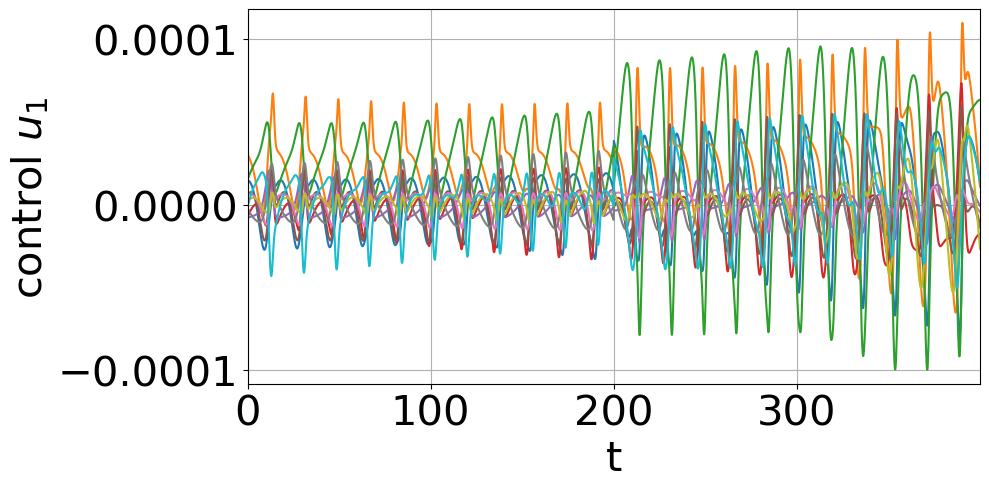

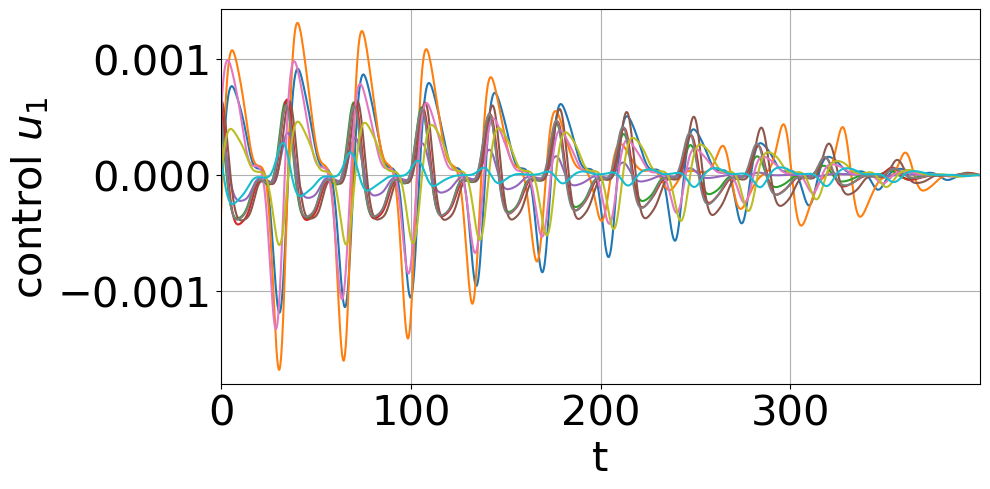

In [51]:
create_plot(y_pred[:4000,:],'control $u_{1}$')
plt.show()
create_plot(y_test[:4000,:],'control $u_{1}$')
plt.show()

In [37]:
#In this case we want to find an optimal control that induces a switching 
#from an initial low state to a high target state. The uncontrolled state and 
#the target state are plotted:

def create_plot(data,ylabel):
    fs=10 #fontsize
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

    # set min and max for scope of y-axis
    minn=np.min(data)
    maxx=np.max(data)
    add=(maxx-minn)/25

    im1=ax.plot(np.arange(0,int(T),dt),data)
    ax.set_xlabel('t',size=fs)
    ax.set_ylabel(ylabel,size=fs)
    ax.set_ylim(minn-add,maxx+add)
    #ax.set_title(title,size=fs, pad=20)
    ax.tick_params(labelsize=fs)
    ax.grid(True)
    ax.margins(0) # remove default margins (matplotlib verision 2+)

    return fig.tight_layout()


In [41]:
def create_plot(data,ylabel):
    fs=30 #fontsize
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

    # set min and max for scope of y-axis
    minn=np.min(data)
    maxx=np.max(data)
    add=(maxx-minn)/25

    im1=ax.plot(np.arange(0,int(T),dt),data)
    ax.set_xlabel('t',size=fs)
    ax.set_ylabel(ylabel,size=fs)
    ax.set_ylim(minn-add,maxx+add)
    ax.tick_params(labelsize=fs)
    ax.grid(True)
    ax.margins(0) # remove default margins (matplotlib verision 2+)

    return fig.tight_layout()